#### Example of text classification with embedding layer from FastText.

Reference pages:
- https://radimrehurek.com/gensim/models/fasttext.html
- https://ai.intelligentonlinetools.com/ml/fasttext-word-embeddings-text-classification-python-mlp/
- Pre-trained FastText embeddings: https://fasttext.cc/docs/en/english-vectors.html
- https://stackoverflow.com/questions/48432300/using-keras-tokenizer-for-new-words-not-in-training-set

The finance complaints dataset was preprocessed in **finance complaints dataset analysis** notebook.

Experiment parameters.

In [1]:
filter_stop_words = True
max_sentence_len = 85
embedding_dim = 300 #from FastText pre-trained vectors
max_vocabulary_size = 300000

Loading balanced dataset.

In [2]:
import pandas as pd
df = pd.read_csv('complaints-balanced.csv')
df.head()

,Unnamed: 0,Product,Consumer_complaint_narrative,category_id
0,0,"Credit reporting, credit repair services, or o...",My XXXX XXXX Account Was Paid Off But They Hav...,0
1,1,"Credit reporting, credit repair services, or o...",I had a citibank checking account which I clos...,0
2,2,"Credit reporting, credit repair services, or o...",I would like to request the suppression of the...,0
3,3,"Credit reporting, credit repair services, or o...",Account from XXXX with a balance is reporting ...,0
4,4,"Credit reporting, credit repair services, or o...",The credit bureaus are reporting inaccurate/ou...,0


In [3]:
print(df.isnull().sum())

Unnamed: 0                      0
Product                         0
Consumer_complaint_narrative    0
category_id                     0
dtype: int64


Text preprocessing

In [4]:
%%time
import re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

def text_preprocessing(txt):
    text = txt
    # removing numbers
    text = re.sub(r'\d+', '', text)
    # removing XXX words
    text = re.sub(r'X*', '', text)
    # to lower case
    text = text.lower()
    # removing punctuation
    text = re.sub(r'[^\w\s]', '', text)
    return text

text = df.Consumer_complaint_narrative.apply(lambda x: text_preprocessing(x))

CPU times: user 2.28 s, sys: 184 ms, total: 2.46 s
Wall time: 2.97 s


In [5]:
def print_example(index):
    print("-"*50)
    print("* BEFORE: {}".format(df.Consumer_complaint_narrative[index]))
    print("\n* AFTER: {}\n".format(text[index]))
    
print_example(0)
print_example(10)

--------------------------------------------------
* BEFORE: My XXXX XXXX Account Was Paid Off But They Have Left The Wrong Information On My Credit Report For 11 Years The Account Should Be Removed It Is Too OldAnd A Medical Account That I Believed To Be Payed Off Has Also Been Left On My Report

* AFTER: my   account was paid off but they have left the wrong information on my credit report for  years the account should be removed it is too oldand a medical account that i believed to be payed off has also been left on my report

--------------------------------------------------
* BEFORE: Please be advised this is my THIRD WRITTEN REQUEST and FINAL WARNING that I fully intend to pursue litigation in accordance with the FCRA to enforce my rights and seek relief and recover all monetary damages that I may be entitled to under Section 616 and Section 617 regarding your continued willful and negligent noncompliance.

Despite two written requests, the unverified items listed below still re

Generating vocabulary index from pretrained FastText vectors.

In [10]:
%%time
from nltk.corpus import stopwords
import numpy as np
import traceback

def is_number(s):
    try:
        float(s)
        return True
    except:
        return False

stop_words = stopwords.words('english')
embeddings_index = {} # store embedding vectors
duplicated_count = {} # store the frequency of duplicated words
vocab_count = 0;
file = open('wiki-news-300d-1M.vec', 'r')
for line in file.readlines():
    values = line.split()
    word = text_preprocessing(values[0])
    if len(word) >= 2 and not is_number(word):
        if (filter_stop_words and word not in stop_words) or (not filter_stop_words):
            vector = np.asarray(values[1:], dtype='float32')
            emb = embeddings_index.get(word)
            if emb is None:
                embeddings_index[word] = vector
                vocab_count += 1
            else:
                embeddings_index[word] = np.add(vector, emb)
                count = duplicated_count.get(word, 0) + 1
                duplicated_count[word] = count
    if vocab_count == max_vocabulary_size:
        break
file.close()

CPU times: user 51.3 s, sys: 532 ms, total: 51.8 s
Wall time: 51.8 s


In [11]:
# using the average vector for duplicated words
for w, c in duplicated_count.items():
    embeddings_index[w] = np.divide(embeddings_index[w], duplicated_count[w])

print("Vocabulary size: ", len(embeddings_index))
print("Number of Duplicated words found: ", len(duplicated_count))

Vocabulary size:  300000
Number of Duplicated words found:  67634


Creating word index and embedding matrix.

In [12]:
word_index = {w: i for i, w in enumerate(embeddings_index.keys(), 1)}

embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros
        embedding_matrix[i] = embedding_vector[:embedding_dim]

Creating train and test sets, with balanced frequency of classes.

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

# encoding labels to one hot vectors
encoder = LabelEncoder()
encoder.fit(df['category_id'])
encoded_Y = encoder.transform(df['category_id'])
Y = np_utils.to_categorical(encoded_Y)

sss = StratifiedShuffleSplit(n_splits=1, 
                             test_size=0.3, 
                             random_state=0)
for train_index, test_index in sss.split(text, df['category_id']):
    train_sentences = text.loc[train_index]
    Y_train = Y[train_index]
    test_sentences = text.loc[test_index]
    test_labels = df['category_id'].loc[test_index]
    Y_test = Y[test_index]

Using TensorFlow backend.


Preparing inputs

In [14]:
%%time

def to_seq(text):
    tokens = text.split()
    seq = []
    for t in tokens:
        index = word_index.get(t, 0)
        if (not filter_stop_words) or (filter_stop_words and t not in stop_words):
            seq.append(index)
    return seq

def docs_to_sequences(docs):
    return docs.apply(lambda x: to_seq(x))

train_seqs = docs_to_sequences(train_sentences)
test_seqs = docs_to_sequences(test_sentences)

# Adding 1 because of reserved 0 index
vocab_size = len(word_index) + 1
print('Vocabulary size: {}'.format(vocab_size))

Vocabulary size: 300001
CPU times: user 2.25 s, sys: 0 ns, total: 2.25 s
Wall time: 2.25 s


In [15]:
from keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(train_seqs, padding='post', maxlen=max_sentence_len)
X_test = pad_sequences(test_seqs, padding='post', maxlen=max_sentence_len)

Model

In [23]:
from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=max_sentence_len, 
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(400, 
                       activation='relu'))
model.add(layers.Dense(5, 
                       activation='softmax'))
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 85, 300)           90000300  
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 300)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 400)               120400    
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 2005      
Total params: 90,122,705
Trainable params: 90,122,705
Non-trainable params: 0
_________________________________________________________________


In [24]:
%%time
history = model.fit(X_train, 
                    Y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, Y_test),
                    batch_size=64)

/home/alexandre/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2516 samples, validate on 1079 samples
Epoch 1/10
2516/2516 [==============================] - 41s 16ms/step - loss: 1.5819 - accuracy: 0.3215 - val_loss: 1.5005 - val_accuracy: 0.6154
Epoch 2/10
2516/2516 [==============================] - 27s 11ms/step - loss: 1.2087 - accuracy: 0.7468 - val_loss: 0.8688 - val_accuracy: 0.7841
Epoch 3/10
2516/2516 [==============================] - 27s 11ms/step - loss: 0.5656 - accuracy: 0.8374 - val_loss: 0.5275 - val_accuracy: 0.8202
Epoch 4/10
2516/2516 [==============================] - 27s 11ms/step - loss: 0.3103 - accuracy: 0.9114 - val_loss: 0.4649 - val_accuracy: 0.8452
Epoch 5/10
2516/2516 [==============================] - 27s 11ms/step - loss: 0.1849 - accuracy: 0.9547 - val_loss: 0.4608 - val_accuracy: 0.8424
Epoch 6/10
2516/2516 [==============================] - 27s 11ms/step - loss: 0.1075 - accuracy: 0.9781 - val_loss: 0.4529 - val_accuracy: 0.8434
Epoch 7/10
2516/2516 [==============================] - 27s 11ms/step - loss

Training Accuracy: 0.9956
Testing Accuracy:  0.8387


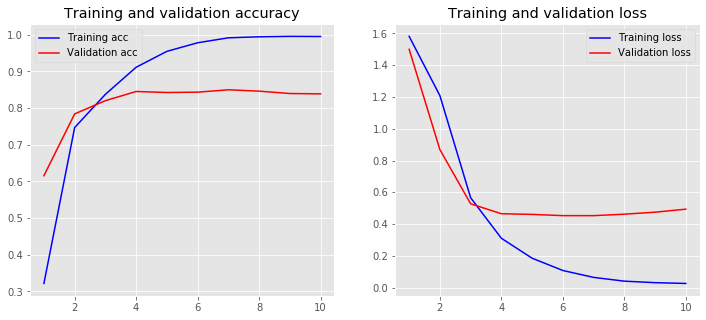

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

loss, accuracy = model.evaluate(X_train, 
                                Y_train, 
                                verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, 
                                Y_test, 
                                verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(history)

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix

my_tags = df.category_id.unique()
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions, labels=my_tags)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

accuracy 0.8387395736793327
confusion matrix
 [[184  15   6   9   2]
 [ 26 161  15  10   4]
 [  7   4 183   4  17]
 [  6   1   7 197   5]
 [  1   2  29   4 180]]
(row=expected, col=predicted)
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       216
           1       0.88      0.75      0.81       216
           2       0.76      0.85      0.80       215
           3       0.88      0.91      0.90       216
           4       0.87      0.83      0.85       216

    accuracy                           0.84      1079
   macro avg       0.84      0.84      0.84      1079
weighted avg       0.84      0.84      0.84      1079



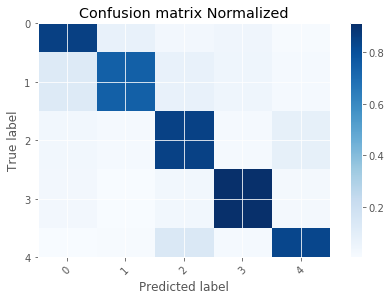

In [28]:
import numpy as np
from sklearn import metrics

Y_pred = model.predict(X_test, 
                       verbose=0)
evaluate_prediction(Y_pred.argmax(axis=1), 
                    Y_test.argmax(axis=1))

print(metrics.classification_report(Y_test.argmax(axis=1), 
                                    Y_pred.argmax(axis=1)))